In [1]:
import torch
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

In [2]:
# Loading dataset

loader = METRLADatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio = 0.8)
train_dataset, val_dataset = temporal_signal_split(train_dataset, train_ratio=0.8)

In [3]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [4]:
# class for simple LSTM

class TrafficLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size:  int, num_layers: int, sequence_len: int):
        super().__init__()
        self.sequence_len = sequence_len
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        # self.linear1 = nn.Linear(hidden_size*sequence_len, int(sequence_len*input_size/2))
        # self.relu1 = nn.ReLU()
        # self.linear2 = nn.Linear(int(sequence_len*input_size/2), sequence_len*input_size)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        #batch_size = x.shape[0]
        x, _ = self.lstm(x)
        #x = x.reshape(batch_size, -1)
        # #print("LSTM output: ", x.shape)
        # x = self.linear1(x)
        # #print("Linear output: ", x.shape)
        # x = self.relu1(x)
        # x = self.linear2(x)
        # x = x.reshape(batch_size, self.sequence_len, self.input_size)
        #x = x[:, -1, :]
        x = self.linear(x)
        return x

In [5]:
# we want to take in features and make tensors of each point
# here, we can decide how far out we want to predict
# train will still be an hour of historical data
# test initially contains next 12 timesteps
# choose just one 

def create_dataset(train, test, timestep_to_predict=1):
    train_data_x = np.array(train.features)
    # just get speed
    train_data_x = train_data_x[:,:,0,:]
    N, S, T = train_data_x.shape
    #print(N,S,T)
    #train_data_x = train_data_x.reshape((N, S*T))
    train_data_y = np.array(train.targets)
    #train_data_y = train_data_y[:,:,timestep_to_predict].reshape(N, S, 1)
    #train_data_y = train_data_y.reshape((N, S*T))
    x_train = torch.tensor(train_data_x).swapaxes(1,2)
    y_train = torch.tensor(train_data_y).swapaxes(1,2)
    max_speed = torch.max(x_train)
    print("max: ", max_speed)
    min_speed = torch.min(x_train)
    x_train = (x_train - min_speed)/(max_speed - min_speed)
    y_train = (y_train - min_speed)/(max_speed - min_speed)
    #x_train = torch.tensor(train_data_x)
    #y_train = torch.tensor(train_data_y)
    print(x_train.shape)
    print(y_train.shape)
    return data.TensorDataset(x_train, y_train), max_speed, min_speed

# this will be generic for train/test
def create_dataset(dataset, normalize):
    data_x = np.array(dataset.features)
    # just get speed
    data_x = data_x[:,:,0,:]
    N, S, T = data_x.shape
    #print(N,S,T)
    #train_data_x = train_data_x.reshape((N, S*T))
    data_y = np.array(dataset.targets)
    #train_data_y = train_data_y[:,:,timestep_to_predict].reshape(N, S, 1)
    #train_data_y = train_data_y.reshape((N, S*T))
    
    x = torch.tensor(data_x).swapaxes(1,2)
    y = torch.tensor(data_y).swapaxes(1,2)
    max_speed = torch.max(x)
    #print("max: ", max_speed)
    min_speed = torch.min(x)
    if(normalize == True):
        x = (x - min_speed)/(max_speed - min_speed)
        y = (y - min_speed)/(max_speed - min_speed)
    #x_train = torch.tensor(train_data_x)
    #y_train = torch.tensor(train_data_y)
    print(x.shape)
    print(y.shape)
    return data.TensorDataset(x, y), max_speed, min_speed


In [6]:
#dataset, max_speed, min_speed = create_dataset(train_dataset, test_dataset)
dataset, max_speed, min_speed = create_dataset(train_dataset, normalize = False)
print("max: ", max_speed)
print("min: ", min_speed)
loader = data.DataLoader(dataset, batch_size = 8, drop_last=True)
#for idx, (data1, label) in enumerate(loader):
#    if idx > 0:
#        break
#    print('label.shape: {}'.format(label.shape))
#    print('label: {}'.format(label))
#    print('data.shape: {}'.format(data1.shape))
# temp = next(iter(loader))
# print(len(temp))
# print(len(temp[0]))
# print(len(temp[0][0]))

val_dataset, max_speed, min_speed = create_dataset(val_dataset, normalize=False)
val_loader = data.DataLoader(val_dataset, batch_size= 8, drop_last=True)

torch.Size([21919, 12, 207])
torch.Size([21919, 12, 207])
max:  tensor(0.8115)
min:  tensor(-2.6522)
torch.Size([5480, 12, 207])
torch.Size([5480, 12, 207])


In [48]:
import time

def train(model, dataloader, loss_func, loss_func_2, device, optimizer):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    total_mae = 0
    for idx, (data1, label) in enumerate(dataloader):
        total_count += 1
        #label = label[:,-1,:]
        label = label.to(device)
        data1 = data1.to(device)
        optimizer.zero_grad()
        
        out = None
        ###########################################################################
        # TODO: compute the logits of the input, get the loss, and do the         #
        # gradient backpropagation.
        ###########################################################################
        if(idx == 0):
           print("input shape: ", data1.shape)
           print("label shape: ", label.shape)
        out = model(data1)
        out = out.swapaxes(1,2)
        label = label.swapaxes(1,2)
        
        loss = loss_func(out, label)
        mean = [53.59967, 0.4982691]
        std = [20.209862, 0.28815305]
        # X = X - means.reshape(1, -1, 1)
        # stds = np.std(X, axis=(0, 2))
        # X = X / stds.reshape(1, -1, 1)
        label = label*std[0] + mean[0]
        out = out*std[0] + mean[0]
        if(idx == 0):
            print("output shape, ", out.shape)
            print("label shape: ", label.shape)
            print("out: ", out[0][0])
            print("label: ", label[0][0])
        total_mae += loss_func_2(out, label).item()
        loss.backward()
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        optimizer.step()

        
        train_rmse = torch.sqrt(loss)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| err {:8.3f}'.format(epoch, idx, len(dataloader),
                                              train_rmse))
            total_acc, total_count = 0, 0
            start_time = time.time()
    #print('Total MAE: ', total_mae)
    #print('Total count: ', total_count)
    return total_mae/total_count

def evaluate(model, dataloader, loss_func, loss_func_2, device):
    model.eval()
    total_acc, total_count = 0, 0
    
    predictions = []
    labels = []
    total_val_rmse = 0
    total_mae = 0
    count = 0
    with torch.no_grad():
        for idx, (label, data1) in enumerate(dataloader):
            count+=1
            label = label.to(device)
            data1 = data1.to(device)
            if(idx == 0):
                print("input shape: ", data1.shape)
                print("label shape: ", label.shape)

            label = label.swapaxes(1,2)
            # undo z-score
            mean = [53.59967, 0.4982691]
            std = [20.209862, 0.28815305]
            # X = X - means.reshape(1, -1, 1)
            # stds = np.std(X, axis=(0, 2))
            # X = X / stds.reshape(1, -1, 1)
            label = label*std[0] + mean[0]
            
            ###########################################################################
            # TODO: compute the logits of the input, get the loss.                    #
            ###########################################################################
            logits = model(data1)
            logits = logits.swapaxes(1,2)
            logits = logits*std[0] + mean[0]
            
            #print(logits.shape)
            #print(label.shape)
            if(idx == 0):
                print("output shape, ", logits.shape)
                print("label shape: ", label.shape)
                print("out: ", logits[0][0])
                print("label: ", label[0][0])
            loss = loss_func(logits, label)
            mae = loss_func_2(logits, label).item()
            ###########################################################################
            #                             END OF YOUR CODE                            #
            ###########################################################################
            val_rmse = torch.sqrt(loss)
            #print("Validation rmse: ", val_rmse)
            #print("Validation mae: ", mae)
            #predictions.append(logits.item())
            #labels.append(label.item())
            total_val_rmse += val_rmse
            total_mae += mae
    #print('Total MAE: ', total_mae)
    #print('Total count: ', count)
    return predictions, labels, total_val_rmse/count, total_mae/count

In [49]:
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
#from torchtext.data.functional import to_map_style_dataset

assert torch.cuda.is_available()
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper parameters
epochs = 10 # epoch
lr = 0.001 # learning rate
input_size = 207
hidden_size = 128

###########################################################################
# TODO: Deinfe the classifier and loss function.
###########################################################################
model = TrafficLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=3, sequence_len=12)
loss_func = F.mse_loss
loss_func2 = F.l1_loss
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

# copy the model to the specified device (GPU)
model = model.to(device)
        
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)
total_accu = None

train_mae = []
val_mae = []
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    print("TRAINING")
    mae = train(model, loader, loss_func, loss_func2, device, optimizer)
    # need to divide by batch size
    train_mae.append(mae)
    print("VALIDATING")
    pred, lab, rmse, mae = evaluate(model, val_loader, loss_func, loss_func2, device)
    val_mae.append(mae)
    #train(model, loader, loss_func2, device, optimizer)
    #accu_val = evaluate(model, valid_dataloader, loss_func, device)
    # if total_accu is not None and total_accu > accu_val:
    #     scheduler.step()
    # else:
    #     total_accu = accu_val
    # print('-' * 59)
    # print('| end of epoch {:3d} | time: {:5.2f}s | '
    #       'valid accuracy {:8.3f} '.format(epoch,
    #                                        time.time() - epoch_start_time,
    #                                        accu_val))
    # print('-' * 59)


TRAINING
input shape:  torch.Size([8, 12, 207])
label shape:  torch.Size([8, 12, 207])
output shape,  torch.Size([8, 207, 12])
label shape:  torch.Size([8, 207, 12])
out:  tensor([0.0298, 0.0344, 0.0365, 0.0399, 0.0420, 0.0415, 0.0412, 0.0409, 0.0399,
        0.0389, 0.0384, 0.0378], device='cuda:0', grad_fn=<SelectBackward0>)
label:  tensor([0.3724, 0.2452, 0.4961, 0.6521, 0.1126, 0.5311, 0.5091, 0.4713, 0.4218,
        0.3909, 0.4761, 0.5641], device='cuda:0')
| epoch   1 |   500/ 2739 batches | err    0.531
| epoch   1 |  1000/ 2739 batches | err    0.331
| epoch   1 |  1500/ 2739 batches | err    0.673
| epoch   1 |  2000/ 2739 batches | err    0.522
| epoch   1 |  2500/ 2739 batches | err    0.595
VALIDATING
input shape:  torch.Size([8, 12, 207])
label shape:  torch.Size([8, 12, 207])
output shape,  torch.Size([8, 207, 12])
label shape:  torch.Size([8, 207, 12])
out:  tensor([63.1206, 62.5460, 62.4907, 62.5638, 61.6943, 62.0214, 62.9280, 62.6523,
        62.4166, 62.4546, 63.1236,

KeyboardInterrupt: 

In [28]:
print(train_mae)
print(val_mae)

[14.185587057546407, 12.242048969914933, 11.714670502901578, 11.147759474313059, 10.851622565985979, 10.618552295976325, 10.299583740281959, 10.150370860174924, 10.130361003222085, 9.851291761553588]
[10.290632960744148, 9.554649032119416, 9.748398754370474, 9.792531063956936, 9.730879141466461, 9.885935759022288, 9.928769738482734, 9.727940661019652, 9.767001316321156, 9.88050444421977]


In [19]:
print(np.array(pred.cpu()).shape)
print(np.array(lab.cpu()).shape)

AttributeError: 'list' object has no attribute 'cpu'

In [29]:
import matplotlib.pyplot as plt

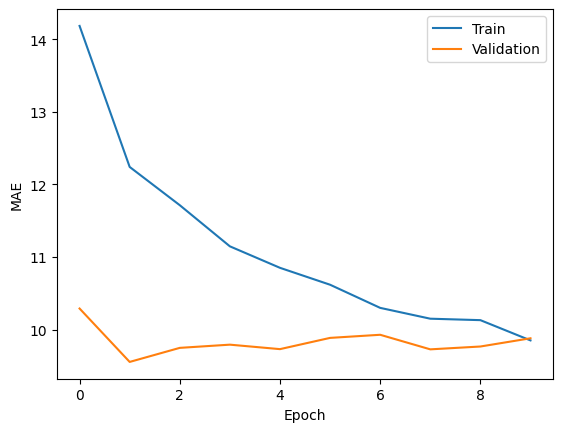

In [30]:
plt.plot(train_mae, label = 'Train')
plt.plot(val_mae, label = 'Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.show()

In [9]:


dataset, max_speed, min_speed = create_dataset(test_dataset, normalize = False)
print("max: ", max_speed)
print("min: ", min_speed)


loader = data.DataLoader(dataset, batch_size = 8, drop_last=True)
for idx, (data1, label) in enumerate(loader):
    if idx > 0:
        break
    # print('label.shape: {}'.format(label.shape))
    # print('label: {}'.format(label))
    # print('data.shape: {}'.format(data1.shape))


torch.Size([6850, 12, 207])
torch.Size([6850, 12, 207])
max:  tensor(0.8115)
min:  tensor(-2.6522)


In [10]:
pred, lab, rmse, mae = evaluate(model, loader, loss_func, loss_func2, device)

Validation rmse:  tensor(14.6936, device='cuda:0')
Validation mae:  tensor(10.7726, device='cuda:0')
Validation rmse:  tensor(12.0266, device='cuda:0')
Validation mae:  tensor(9.0884, device='cuda:0')
Validation rmse:  tensor(9.6805, device='cuda:0')
Validation mae:  tensor(7.4478, device='cuda:0')
Validation rmse:  tensor(10.3309, device='cuda:0')
Validation mae:  tensor(6.9159, device='cuda:0')
Validation rmse:  tensor(13.7294, device='cuda:0')
Validation mae:  tensor(9.1416, device='cuda:0')
Validation rmse:  tensor(18.4837, device='cuda:0')
Validation mae:  tensor(13.3341, device='cuda:0')
Validation rmse:  tensor(21.8749, device='cuda:0')
Validation mae:  tensor(16.1495, device='cuda:0')
Validation rmse:  tensor(21.9160, device='cuda:0')
Validation mae:  tensor(15.6480, device='cuda:0')
Validation rmse:  tensor(22.2702, device='cuda:0')
Validation mae:  tensor(15.8003, device='cuda:0')
Validation rmse:  tensor(18.6563, device='cuda:0')
Validation mae:  tensor(12.9615, device='cuda

In [11]:
print("Predictions: (", len(pred), ', ', len(pred[0]), ')')
print("Labels: (", len(lab), ', ', len(lab[0]), ')')
print("Average RMSE: ", rmse)
print("Average MAE: ", mae)
print(pred[0][0].shape)
print(lab[0][0].shape)

Predictions: ( 856 ,  8 )
Labels: ( 856 ,  8 )
Average RMSE:  tensor(21.1774, device='cuda:0')
Average MAE:  tensor(15.9549, device='cuda:0')
torch.Size([12, 207])
torch.Size([12, 207])
